In [1]:
%run init_notebook.py

In [5]:
import pandas as pd
df = pd.read_csv(base_processed + 'engineerd2_cat.csv')

In [6]:
# vérifications
if 'index' in df.columns:
    print("Il existe une colonne 'index' dans le DataFrame.")
else:
    print("Il n'y a pas de colonne 'index' dans le DataFrame.")

# Vérifier s'il y a des NaN dans la colonne 'z (Wh/km)'
if df['z (Wh/km)'].isnull().any():
    print("Il y a des valeurs NaN dans la colonne 'z (Wh/km)'.")
else:
    print("Il n'y a pas de valeurs NaN dans la colonne 'z (Wh/km)'.")

if df.duplicated().any():
    print("Il existe des duplicats dans le DataFrame.")
else:
    print("Il n'y a pas de duplicats dans le DataFrame.")

nan_count = df["Ewltp (g/km)"].isna().sum()
print(f"On vérifie l'absence de Nan en variable cible 'Ewltp (g/km)': {nan_count} NaN")


Il n'y a pas de colonne 'index' dans le DataFrame.
Il n'y a pas de valeurs NaN dans la colonne 'z (Wh/km)'.
Il n'y a pas de duplicats dans le DataFrame.
On vérifie l'absence de Nan en variable cible 'Ewltp (g/km)': 0 NaN


In [ ]:
"""
# Si les tests ci-dessus ne passent pas, vous pouvez utiliser le code suivant pour nettoyer le DataFrame:

# Exclure les colonnes 'Cn' et 'ec (ch)' pour la vérification des duplicats
columns_to_check = df.columns.difference(['index', 'Cn'])

# Identifier les lignes dupliquées en excluant ces colonnes 
duplicates = df[df.duplicated(subset=columns_to_check, keep=False)]

# Afficher les lignes dupliquées
print("Duplicate Rows (all fields identical except some columns):")
print(duplicates)

# remplacer les NaN par zéro pour "z (Wh/km)"
df["z (Wh/km)"].fillna(0, inplace=True)

# Identify duplicate rows
duplicates = df[df.duplicated(keep=False)]

# Display duplicate rows
print("Duplicate Rows (all fields identical):")
print(duplicates)

#suppression de nan en valeur cible
df.dropna(subset=["Ewltp (g/km)"], inplace=True)

# Drop duplicate rows
df_cleaned = df.drop_duplicates()

print("DataFrame after removing duplicates:")
print(df_cleaned)
df=df_cleaned
"""

In [ ]:
"""
# quelques visualisations si nécessaire

display(df.head())
print ("************")

display(df.describe())
print ("************")
pd.set_option('display.max_columns', 50)
display(df.info())
"""

***

Les données chargées ont déjà reçu tous les traitements :
corrections métier, traitement des extrêmes/outliers, dichotomisations, traitement des NaN

Nous passons ici à la :
# standardisation

***


Notre variable cible est Ewltp (g/km).

Nous devons standardiser/normaliser les autres variables numériques (explicatives).
Pour les variables W (mm), At1 (mm), ec (cm3), ep (KW), z (Wh/km), Electric range (km),
on a pu constater visuellement qu'elles n'avaient pas de distribution normale, et comme on a des outliers assumés, ce sera un robust scaling pour ces variables.
Il reste un doute sur "m (kg)" qui présente une courbe qui pourrait être normale:

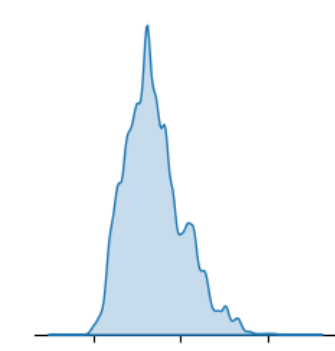

Comme nous avons > 5000 données, Shapiro-Wilk n'est pas conseillé, on teste selon Anderson-Darling


In [7]:
"""
# Nous avons vérifié en 02/2025 la distribution de m (kg) , et n'aurons pas besoin de le refaire ensuite.
from scipy.stats import anderson

# Réaliser le test d'Anderson-Darling
result = anderson(df["m (kg)"])
print('Statistique de test:', result.statistic)
print('Seuils critiques:', result.critical_values)

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f'A {sl}% de niveau de signification: les données suivent une distribution normale (échec du rejet de H0)')
    else:
        print(f'A {sl}% de niveau de signification: les données ne suivent pas une distribution normale (rejet de H0)')
"""


'\n# Nous avons vérifié en 02/2025 la distribution de m (kg) , et n\'aurons pas besoin de le refaire ensuite.\nfrom scipy.stats import anderson\n\n# Réaliser le test d\'Anderson-Darling\nresult = anderson(df["m (kg)"])\nprint(\'Statistique de test:\', result.statistic)\nprint(\'Seuils critiques:\', result.critical_values)\n\nfor i in range(len(result.critical_values)):\n    sl, cv = result.significance_level[i], result.critical_values[i]\n    if result.statistic < cv:\n        print(f\'A {sl}% de niveau de signification: les données suivent une distribution normale (échec du rejet de H0)\')\n    else:\n        print(f\'A {sl}% de niveau de signification: les données ne suivent pas une distribution normale (rejet de H0)\')\n'

Au final il est donc indiqué de procéder à une standardisation robust scaling pour toutes nos variables explicatives numériques continues.


Avant de normaliser, on effectue la séparation en jeux de données train et test afin d'éviter les fuites de données.
Et pour ceci, on définit préalablement quelle est notre target (variable cible) et data (variables explicatives)  

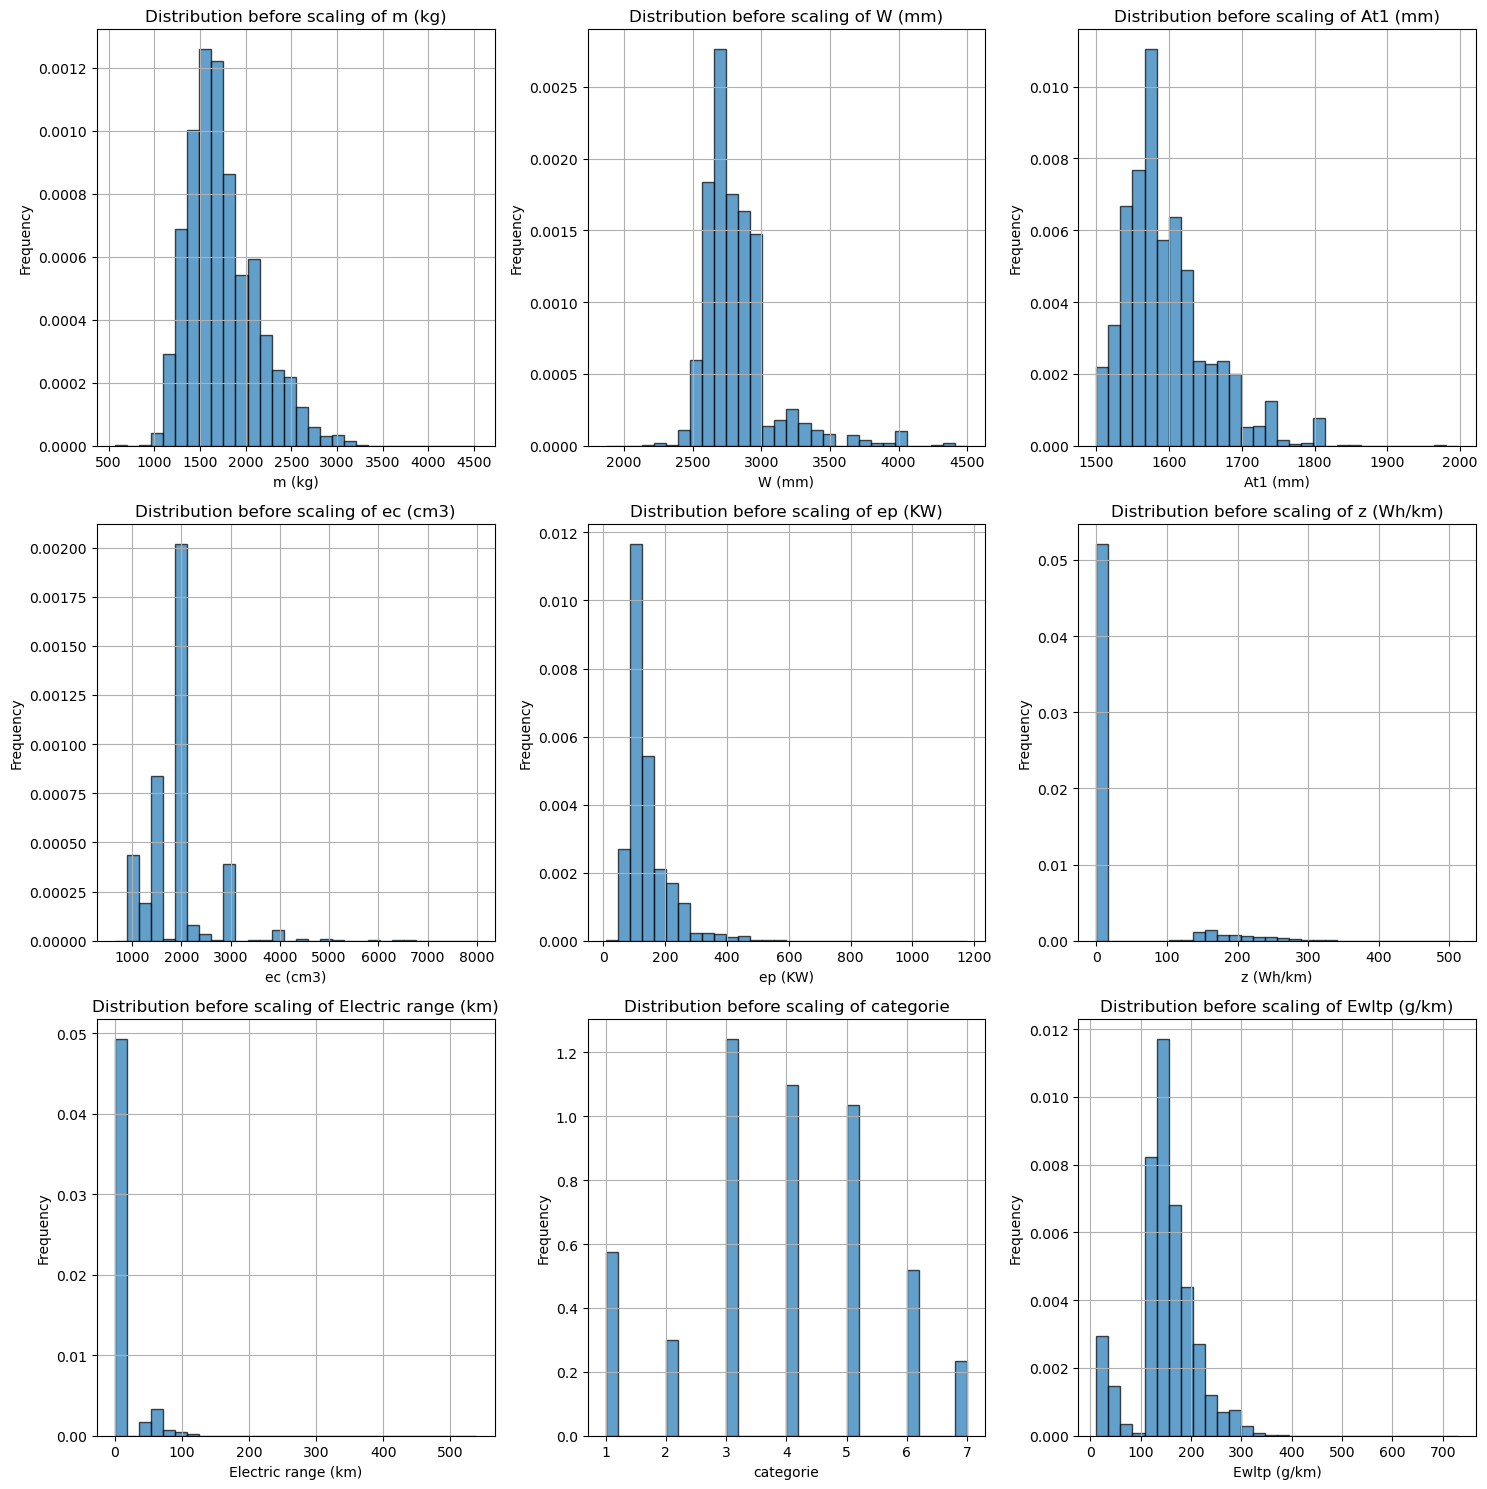

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Colonnes dont on veut afficher les distributions
columns_to_plot = ["m (kg)", "W (mm)", "At1 (mm)", "ec (cm3)", "ep (KW)", "z (Wh/km)", "Electric range (km)", "categorie", "Ewltp (g/km)"]

# Nombre de colonnes pour les sous-graphiques
num_columns = 3
num_plots = len(columns_to_plot)
num_rows = (num_plots + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Aplatir les axes pour une itération plus simple
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    if column in df.columns:
        axes[i].hist(df[column], bins=30, alpha=0.7, edgecolor='black', density=True)
        axes[i].set_title(f'Distribution before scaling of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)
    else:
        print(f"Column '{column}' not found in DataFrame.")

# Supprimer les sous-graphiques vides (s'il y en a)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [9]:
# séparation en cible et features
X = df.drop(columns=['Ewltp (g/km)', 'categorie'])
y = df['Ewltp (g/km)']
y_cat = df['categorie']


In [13]:
# code pour un scaler différent pour les colonnes à majorité de zéros.
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd

# Nos colonnes à scaler avec des scalers différents
standard_cols = []
robust_cols = ["m (kg)", "W (mm)", "At1 (mm)", "ec (cm3)", "ep (KW)"]
min_max_cols = ["z (Wh/km)", "Electric range (km)"]

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, _, y_train_cat, y_test_cat = train_test_split(X, y_cat, test_size=0.2, random_state=42)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()


# Application du StandardScaler aux colonnes sélectionnées dans l'ensemble d'entraînement puis test
if standard_cols:
    standard_scaler = StandardScaler()
    X_train_scaled[standard_cols] = standard_scaler.fit_transform(X_train[standard_cols])
    X_test_scaled[standard_cols] = standard_scaler.transform(X_test[standard_cols])
    # Sauvegarde du scaler
    joblib.dump(standard_scaler, base_models + 'standard_scaler.pkl')



# Application du RobustScaler aux colonnes sélectionnées dans l'ensemble d'entraînement
if robust_cols:
    robust_scaler = RobustScaler()
    X_train_scaled[robust_cols] = robust_scaler.fit_transform(X_train[robust_cols])
    X_test_scaled[robust_cols] = robust_scaler.transform(X_test[robust_cols])
    # Sauvegarde du scaler
    joblib.dump(robust_scaler, base_models + 'robust_scaler.pkl')


# Application du MinMaxScaler aux colonnes sélectionnées dans l'ensemble d'entraînement
if min_max_cols:
    min_max_scaler = MinMaxScaler()
    X_train_scaled[min_max_cols] = min_max_scaler.fit_transform(X_train[min_max_cols])
    X_test_scaled[min_max_cols] = min_max_scaler.transform(X_test[min_max_cols])
    # Sauvegarde des scalers
    joblib.dump(min_max_scaler, base_models + 'min_max_scaler.pkl')




# Mémo pour réutiliser les scalers plus tard:
# standard_scaler = joblib.load(base_models + 'standard_scaler.pkl')
# robust_scaler = joblib.load(base_models + 'robust_scaler.pkl')
# min_max_scaler = joblib.load(base_models + 'min_max_scaler.pkl')
# new_data_scaled = new_data.copy()
# new_data_scaled[standard_cols] = standard_scaler.transform(new_data[standard_cols])
# new_data_scaled[robust_cols] = robust_scaler.transform(new_data[robust_cols])
# new_data_scaled[min_max_cols] = min_max_scaler.transform(new_data[min_max_cols])



In [14]:

# pour vérifier visuellement que les données ont été bien scalées
print(X_train_scaled.describe())
print("*"*50)
print(X_test_scaled.head())


             m (kg)        W (mm)      At1 (mm)      ec (cm3)       ep (KW)  \
count  98939.000000  98939.000000  98939.000000  98939.000000  98939.000000   
mean       0.138284      0.144852      0.255247     -0.142827      0.546516   
std        0.772482      1.242685      0.947835      1.265562      1.426046   
min       -2.270492     -4.482927     -1.290323     -2.643863     -2.400000   
25%       -0.411885     -0.570732     -0.322581     -0.945674     -0.222222   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.588115      0.429268      0.677419      0.054326      0.777778   
max        4.663934      8.360976      6.725806     12.122736     23.600000   

          z (Wh/km)  Electric range (km)          IT28          IT29  \
count  98939.000000         98939.000000  98939.000000  98939.000000   
mean       0.041762             0.013771      0.120003      0.463104   
std        0.121887             0.041347      0.324967      0.498639   


On peut avoir des doutes sur z (Wh/km) et Electric range, dont les maxi sont grands.
Notamment, Electric range a le meme max qu'avant la standardisation

***
Standardisation terminée  
On sauvegarde les données

In [15]:
X_train_scaled.to_csv(base_processed + 'X_train_scaled.csv', index=False)
X_test_scaled.to_csv(base_processed + 'X_test_scaled.csv', index=False)
y_train.to_csv(base_processed + 'y_train.csv', index=False)
y_test.to_csv(base_processed + 'y_test.csv', index=False)
y_train_cat.to_csv(base_processed + 'y_train_cat.csv', index=False)
y_test_cat.to_csv(base_processed + 'y_test_cat.csv', index=False)


Column 'categorie' not found in DataFrame.
Column 'Ewltp (g/km)' not found in DataFrame.


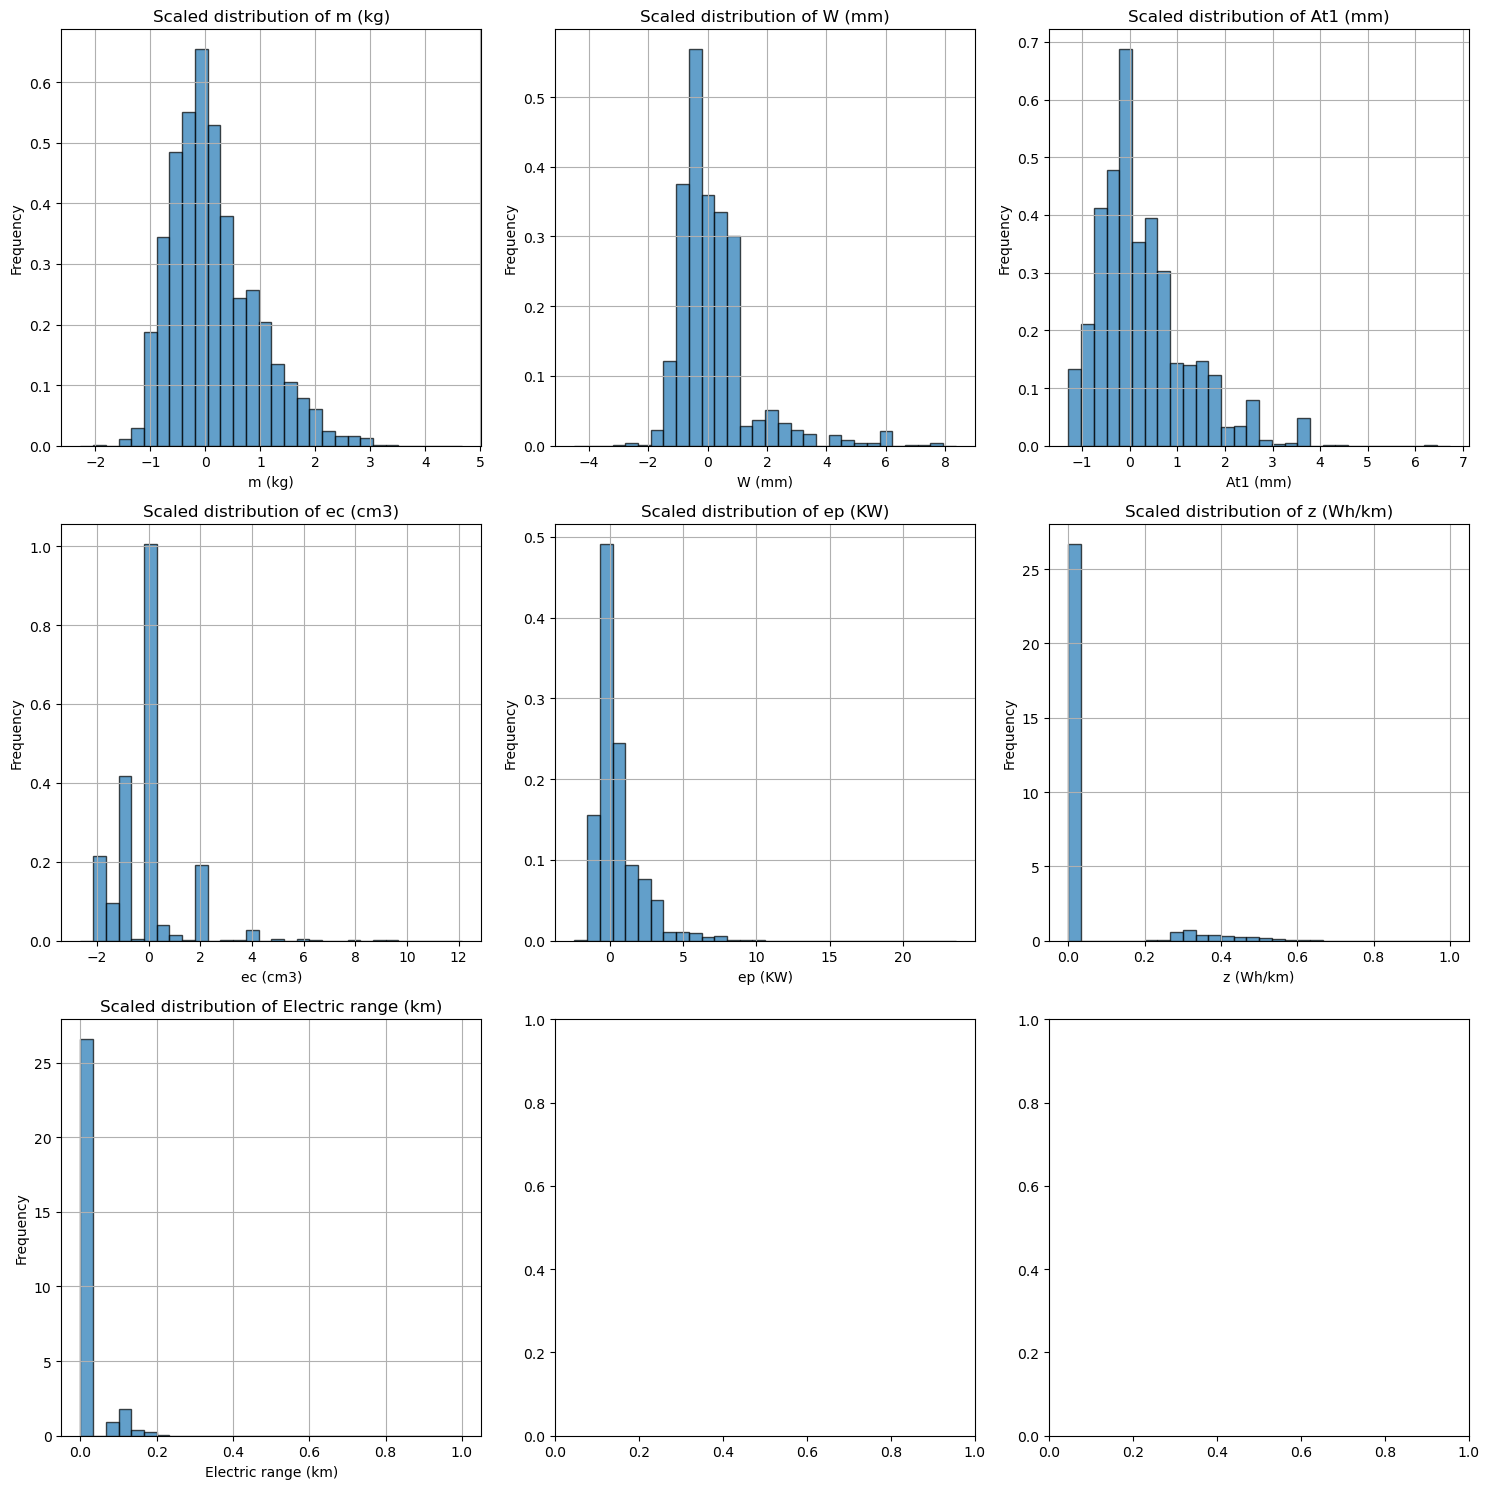

In [16]:
# on fait les mêmes plot que plus haut mais avec les données scalées

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Aplatir les axes pour une itération plus simple
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    if column in X_train_scaled.columns:
        axes[i].hist(X_train_scaled[column], bins=30, alpha=0.7, edgecolor='black', density=True)
        axes[i].set_title(f'Scaled distribution of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)
    else:
        print(f"Column '{column}' not found in DataFrame.")

# Supprimer les sous-graphiques vides (s'il y en a)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
